In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
from loguru import logger as log

In [2]:
# Custom packages
from dtw import *
from utils import convert_warp_path_to_timeseries
from plotting import create_graph

In [18]:
log.remove()
log.add(sys.stderr, level="DEBUG");

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Define initial parameters

For example, if biostratigraphic data indicates that the age of oldest sediments in the core cannot exceed 245,000 years, set the `max_age` variable to 245. Similarly, set the `min_age` variable to the minimum age you expect the core top to be. For piston core from the ocean bottom, it is a good idea to set this to 0, but if data is available, such as for example the topmost 10k years are missing, this variable can be set to start at something else than 0. 

In [4]:
min_age = 0  # in kiloyears (kyrs) before present
max_age = 400 # in kiloyears (kyrs) before present
time_step = 5  # in kiloyears

#### Set parameters for the run

In [37]:
# 2nd run
# ref = "1100"
# ref_path = f'out_warping-paths/dist-vs-time_core_{ref}_d18O_pl_LR04stack.txt'
# ref_cols = ['time', 'value']
# names = ['1150']
# variables = ['d18O', 'aragonite']

# # # Validation
# ref = "LR04stack"
# ref_path = f'data/{ref}.csv'
# ref_cols = ['time', 'd18O']
# names = ['validate_LR04']
# variables = ['d18O']

### Find best distance: LR04stack vs M74/4-1100

##### Run parameters

In [5]:
ref = "LR04stack"
ref_path = f'../data/{ref}.csv'
ref_cols = ['time', 'd18O']
names = ['1100']
variables = ['d18O', 'aragonite']

##### Load target (reference) data and limit by `min_age` and `max_age`

In [6]:
target = pd.read_csv(ref_path, usecols=ref_cols) 
target = target[target['time'] <= max_age]
target = target[target['time'] >= min_age]

In [23]:
target.head()

,time,d18O
0,0.0,3.23
1,1.0,3.23
2,2.0,3.18
3,3.0,3.29
4,4.0,3.30


##### Load unknown data

In [7]:
data = pd.read_csv(f'../data/core_1100_d18O_pl.csv', skip_blank_lines=True)

In [24]:
data.head()

,depth_m,d18O_pl
0,0.01,-1.924
1,0.06,-2.673
2,0.11,-2.551
3,0.16,-2.537
4,0.21,-2.290


##### Define DTW object

In [56]:
dtw = SedimentDTW(target=target['d18O'], 
                  data=data['d18O_pl'], 
                  normalize=True, 
                  smooth=True, 
                  window_size=11, 
                  polynomial=3)

2023-03-27 21:57:25.829 | DEBUG    | dtw:__init__:76 - Time-warp object created successfully!


##### Find simple distance

In [28]:
simple_distance = dtw.simple_distance()
print(round(simple_distance, 2))

7.02


##### Find minimum distance iteratively

FileNotFoundError: [Errno 2] No such file or directory: 'out_warping-paths/dist-vs-time_core_1100_d18O_pl_LR04stack.png'

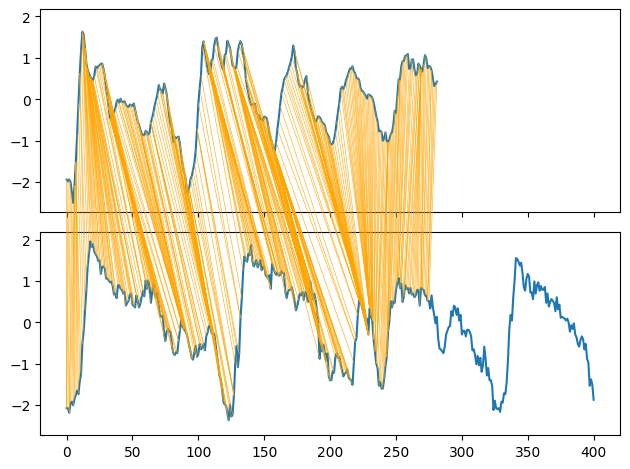

In [72]:
distance, target_time, min_distances = dtw.find_min_distance(min_age, max_age, time_step, 
                                                             name=f'dist-vs-time_{file.replace(".csv", "")}_{ref}.png', 
                                                             warp_path=True, plot_warping_path=True)

In [ ]:
print(f'Found minimum distance: {round(distance, 2)} at target time {target_time[0]} kyrs')

In [49]:
 # Move through cores and find distance(s)
for name in names:        
    for var in variables:

        files = [x for x in os.listdir('../data') if var in x and name in x]  
        for file in files:

            data = pd.read_csv(f'../data/{file}', skip_blank_lines=True)

            dtw = SedimentTimeWarp(target=target, data=data, normalize=True, smooth=True, window_size=11, polynomial=3)               
            simple_distance = dtw.simple_distance()  
            log.debug(f'Calculated distance (simple): {round(simple_distance, 2)} (rounded)')

            distance, target_time, min_distances = dtw.find_min_distance(0, max_age, time_step, 
                                                                         name=f'dist-vs-time_{file.replace(".csv", "")}_{ref}.png', warp_path=True, plot_warping_path=True)                
            log.debug(f'Found minimum distance: {round(distance, 2)} at target time {target_time[0]} kyrs')       

            base_path = '../out_warping-paths'
            if not os.path.exists(base_path):
                os.makedirs(base_path, exist_ok=True)

            # Use best path to create
            data_list = data.iloc[:,1].to_list()
            target_list = target.iloc[:,0].to_list()
            dataset = convert_warp_path_to_timeseries(target_list, data_list, dtw.best_path)                
            dataset.to_csv(os.path.join(base_path, f'dist-vs-time_{file.replace(".csv", "")}_{ref}.txt'), index=False)

            # # Create plot
            # create_graph(min_distances, name, file, distance, target_time)

2023-03-26 22:39:05.627 | DEBUG    | sediment_time_warp:__init__:77 - Using 'd18O' as target and 'd18O_pl' as data
2023-03-26 22:39:05.628 | DEBUG    | sediment_time_warp:__init__:78 - normalization set to True; smoothing set to True
2023-03-26 22:39:05.629 | DEBUG    | sediment_time_warp:__init__:79 - Time-warp object created successfully!
2023-03-26 22:39:06.182 | DEBUG    | __main__:<module>:12 - Calculated distance (simple): 7.02 (rounded)
2023-03-26 22:39:06.183 | DEBUG    | sediment_time_warp:find_min_distance:164 - End time: 5
2023-03-26 22:39:06.193 | DEBUG    | sediment_time_warp:find_min_distance:164 - End time: 10
2023-03-26 22:39:06.210 | DEBUG    | sediment_time_warp:find_min_distance:164 - End time: 15
2023-03-26 22:39:06.234 | DEBUG    | sediment_time_warp:find_min_distance:164 - End time: 20
2023-03-26 22:39:06.264 | DEBUG    | sediment_time_warp:find_min_distance:164 - End time: 25
2023-03-26 22:39:06.301 | DEBUG    | sediment_time_warp:find_min_distance:164 - End time

KeyboardInterrupt: 